<a href="https://colab.research.google.com/github/anubhavgupta1/Dive-Into-Deep-Learning/blob/main/Softmax%20Regression/Implementation%20from%20Scratch/tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Softmax Regression

In [ ]:
!pip install d2l==0.16.1

In [2]:
from d2l import tensorflow as d2l
import tensorflow as tf
from IPython import display

### Reading the minibatch

In [ ]:
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f9bde8679e8>,
      dtype=object)

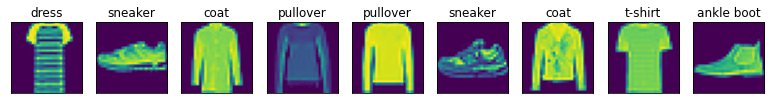

In [4]:
n = 9
for X, y in train_iter:
  break;
d2l.show_images(tf.reshape(X[0:n], (n, 28, 28)), 1, n, titles=d2l.get_fashion_mnist_labels(y))

###Initializing Model Parameters

In [5]:
num_inputs = 784
num_outputs = 10

W = tf.Variable(tf.random.normal(shape=(num_inputs, num_outputs),
                                 mean=0, stddev=0.01))
b = tf.Variable(tf.zeros(num_outputs))

print("W : \n", W[0])
print("b : \n", b)

W : 
 tf.Tensor(
[ 1.5710235e-02 -8.4854597e-05 -1.0092829e-02  1.0922913e-02
 -1.9433918e-04  3.2122077e-03  5.1542539e-03  1.1902058e-02
 -3.3909150e-03  6.0400967e-03], shape=(10,), dtype=float32)
b : 
 <tf.Variable 'Variable:0' shape=(10,) dtype=float32, numpy=array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)>


### Defining the Model

In [6]:
def softmax(X):
    X_exp = tf.exp(X)
    partition = tf.reduce_sum(X_exp, 1, keepdims=True)
    return X_exp / partition  # The broadcasting mechanism is applied here

In [7]:
def net(X):
    return softmax(tf.matmul(tf.reshape(X, (-1, W.shape[0])), W) + b)

### Defining the Loss Function

In [8]:
def cross_entropy(y_hat, y):
    return -tf.math.log(tf.boolean_mask(y_hat, tf.one_hot(y, depth=y_hat.shape[-1])))

### Classification Accuracy

In [9]:
def accuracy(y_hat, y):  #@save
    """Compute the number of correct predictions."""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = tf.argmax(y_hat, axis=1)
    cmp = tf.cast(y_hat, y.dtype) == y
    return float(tf.reduce_sum(tf.cast(cmp, y.dtype)))

In [10]:
def evaluate_accuracy(net, data_iter):  #@save
    """Compute the accuracy for a model on a dataset."""
    metric = Accumulator(2)  # No. of correct predictions, no. of predictions
    for X, y in data_iter:
        metric.add(accuracy(net(X), y), tf.size(y).numpy())
    return metric[0] / metric[1]

In [11]:
class Accumulator:  #@save
    """For accumulating sums over `n` variables."""
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [12]:
evaluate_accuracy(net, test_iter)

0.1019

### Training

In [13]:
class Updater():  #@save
    """For updating parameters using minibatch stochastic gradient descent."""
    def __init__(self, params, lr):
        self.params = params
        self.lr = lr

    def __call__(self, batch_size, grads):
        d2l.sgd(self.params, grads, self.lr, batch_size)

In [14]:
def train_epoch(net, train_iter, loss, updater):  #@save
    """The training loop defined in Chapter 3."""
    # Sum of training loss, sum of training accuracy, no. of examples
    metric = Accumulator(3)
    for X, y in train_iter:
        # Compute gradients and update parameters
        with tf.GradientTape() as tape:
            y_hat = net(X)
            # Keras implementations for loss takes (labels, predictions)
            # instead of (predictions, labels) that users might implement
            # in this book, e.g. `cross_entropy` that we implemented above
            if isinstance(loss, tf.keras.losses.Loss):
                l = loss(y, y_hat)
            else:
                l = loss(y_hat, y)
        if isinstance(updater, tf.keras.optimizers.Optimizer):
            params = net.trainable_variables
            grads = tape.gradient(l, params)
            updater.apply_gradients(zip(grads, params))
        else:
            updater(X.shape[0], tape.gradient(l, updater.params))
        # Keras loss by default returns the average loss in a batch
        l_sum = l * float(tf.size(y)) if isinstance(
            loss, tf.keras.losses.Loss) else tf.reduce_sum(l)
        metric.add(l_sum, accuracy(y_hat, y), tf.size(y))
    # Return training loss and training accuracy
    return metric[0] / metric[2], metric[1] / metric[2]

In [15]:
class Animator:  #@save
    """For plotting data in animation."""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        # Incrementally plot multiple lines
        if legend is None:
            legend = []
        d2l.use_svg_display()
        self.fig, self.axes = d2l.plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # Use a lambda function to capture arguments
        self.config_axes = lambda: d2l.set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # Add multiple data points into the figure
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

In [16]:
def train(net, train_iter, test_iter, loss, num_epochs, updater):  #@save
    """Train a model (defined in Chapter 3)."""
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.3, 0.9],
                        legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        train_metrics = train_epoch(net, train_iter, loss, updater)
        test_acc = evaluate_accuracy(net, test_iter)
        animator.add(epoch + 1, train_metrics + (test_acc,))
    train_loss, train_acc = train_metrics
    assert train_loss < 0.5, train_loss
    assert train_acc <= 1 and train_acc > 0.7, train_acc
    assert test_acc <= 1 and test_acc > 0.7, test_acc

In [17]:
updater = Updater([W, b], lr=0.1)

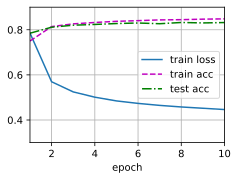

In [18]:
num_epochs = 10
train(net, train_iter, test_iter, cross_entropy, num_epochs, updater)

In [19]:
def predict(net, test_iter, n=6):  #@save
    """Predict labels (defined in Chapter 3)."""
    for X, y in test_iter:
        break
    trues = d2l.get_fashion_mnist_labels(y)
    preds = d2l.get_fashion_mnist_labels(tf.argmax(net(X), axis=1))
    titles = [true +'\n' + pred for true, pred in zip(trues, preds)]
    d2l.show_images(
        tf.reshape(X[0:n], (n, 28, 28)), 1, n, titles=titles[0:n])

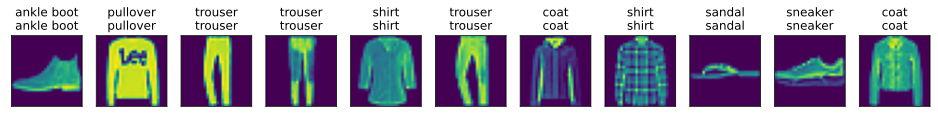

In [20]:
predict(net, test_iter, n=11)